# Definir componentes

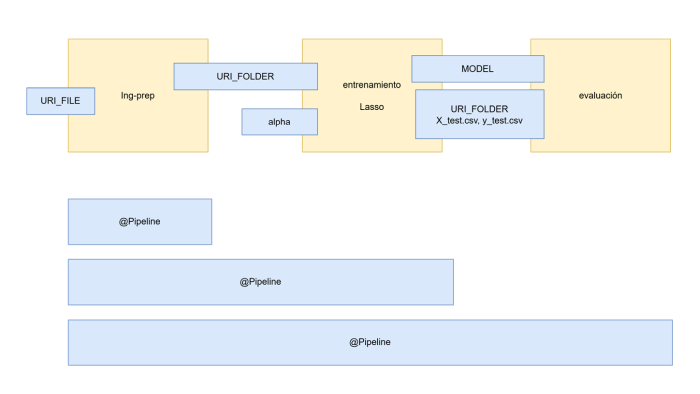

In [ ]:
pip show azure-ai-ml

## Conectar a workspace

In [ ]:
# conectar
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

ml_client = MLClient.from_config(credential=DefaultAzureCredential())

print(f"Conectado al Workspace: {ml_client.workspace_name}")

## Crear los directorios

In [ ]:
import os

# create a folder for the script files
script_folder = './src'
os.makedirs(script_folder, exist_ok=True)

os.makedirs(f'{script_folder}/ing-prep-data', exist_ok=True)
os.makedirs(f'{script_folder}/train-model', exist_ok=True)
os.makedirs(f'{script_folder}/eval-model', exist_ok=True)

print(script_folder, 'folders created')

## Definir componentes

### Ingesta

In [ ]:
%%writefile ./src/ing-prep-data/ing-prep-data.py

import pandas as pd
import argparse
from pathlib import Path

def main(args):
    df = read_data(args.input_data)
    df2 = preprocess_data(df)
    output_df = df2.to_csv((Path(args.output_data) / "housing_prep.csv"), index = False)


def read_data(uri):
    # 1. Cargar los datos
    data = pd.read_csv(uri)
    # 2. Inspeccionar las columnas
    print(data.columns)

    return data


def preprocess_data(data):
    # 3. Descartar columnas no significativas
    # Las columnas 'date', 'street', 'city', 'statezip', 'country' no son relevantes para la predicción
    columns_to_drop = ['date', 'street', 'city', 'statezip', 'country']
    data = data.drop(columns=columns_to_drop)

    return data


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_data", dest='input_data', type=str)
    parser.add_argument("--output_data", dest='output_data',type=str)
    args = parser.parse_args()

    return args


# run script
if __name__ == "__main__":
    args = parse_args()
    main(args)

In [ ]:
%%writefile ing-prep-data.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
name: ing_prep_data_housing_ric
display_name: Ingesta y Preprocesamiento de Datos Housing
version: 2
type: command
inputs:
  input_data: 
    type: uri_file
outputs:
  output_data:
    type: uri_folder
code: ./src/ing-prep-data
environment: azureml:AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest
command: >-
  python ing-prep-data.py
  --input_data ${{inputs.input_data}}
  --output_data ${{outputs.output_data}}

In [ ]:
# registrar componente
from azure.ai.ml import load_component

ing_prep_data = load_component(source="ing-prep-data.yml")

reg_ing_prep_data = ml_client.components.create_or_update(ing_prep_data)
reg_ing_prep_data

### training

In [ ]:
%%writefile ./src/train-model/train-model.py

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import argparse
from pathlib import Path

import mlflow
import glob


def main(args):
    mlflow.autolog()

    df = get_data(args.input_data)
    model, X_test, y_test = train_model('price', df, args.alpha, 0.3)

    mlflow.sklearn.save_model(model, args.model_output)

    X_test.to_csv((Path(args.output_data) / "housing_X_test.csv"), index = False)
    y_test.to_csv((Path(args.output_data) / "housing_y_test.csv"), index = False)

    

def get_data(data_path):

    all_files = glob.glob(data_path + "/*.csv")
    df = pd.concat((pd.read_csv(f) for f in all_files), sort=False)
    
    return df


def train_model(target, data, alpha, test_size=0.2):
    # 4. Separar características (X) y objetivo (y)
    X = data.drop(columns=[target])  # Todas las columnas excepto target
    y = data[target]  # Variable objetivo

    # 5. Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)

    # 6. Preprocesamiento de datos
    # Identificar columnas numéricas y categóricas
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Crear un preprocesador con StandardScaler para numéricas y OneHotEncoder para categóricas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ]
    )

    # 7. Crear un pipeline con el preprocesador y el modelo Lasso
    mlflow.log_param("alpha:", alpha)

    lasso_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        # alpha es el parámetro de regularización
        ('regressor', Lasso(alpha=alpha, random_state=42))
    ])

    # 8. Entrenar el modelo
    lasso_model.fit(X_train, y_train)

    return lasso_model, X_test, y_test


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_data", dest='input_data', type=str)
    parser.add_argument("--alpha", dest='alpha', type=float, default=0.01)
    
    parser.add_argument("--model_output", dest='model_output',type=str)
    parser.add_argument("--output_data", dest='output_data',type=str)
    args = parser.parse_args()

    return args


# run script
if __name__ == "__main__":
    args = parse_args()
    print('args:', args)
    main(args)

In [ ]:
%%writefile train-model.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
name: train_model_housing_ric
display_name: Entrenamiento de Modelo Lasso
version: 2
type: command
inputs:
  input_data: 
    type: uri_folder
  alpha:
    type: number
    default: 0.01
outputs:
  model_output:
    type: mlflow_model
  output_data:
    type: uri_folder
code: ./src/train-model/
environment: azureml:AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest
command: >-
  python train-model.py
  --input_data ${{inputs.input_data}}
  --alpha ${{inputs.alpha}}
  --model_output ${{outputs.model_output}}
  --output_data ${{outputs.output_data}}

In [ ]:
# registrar componente
from azure.ai.ml import load_component

train_model = load_component(source="train-model.yml")

reg_train_model = ml_client.components.create_or_update(train_model)
reg_train_model

### evaluación

In [ ]:
%%writefile ./src/eval-model/eval-model.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import argparse
from pathlib import Path

import mlflow


def main(args):
    mlflow.autolog()

    model = mlflow.sklearn.load_model(args.model_input)
    X_test, y_test = get_data(args.input_data)
    evaluate_model(model, X_test, y_test)


def get_data(data_path):
    X_test = pd.read_csv((Path(data_path) / "housing_X_test.csv"))
    y_test = pd.read_csv((Path(data_path) / "housing_y_test.csv"))

    return X_test, y_test


def evaluate_model(lasso_model, X_test, y_test):
    # 9. Hacer predicciones
    y_pred = lasso_model.predict(X_test)

    # 10. Evaluar el modelo usando MSE
    mse = mean_squared_error(y_test, y_pred)
    print(f"Error Cuadrático Medio (MSE): {mse:.2f}")

    # 11. Calcular la varianza de los datos objetivo
    variance = np.var(y_test.values)
    print(f"Varianza de los datos objetivo: {variance:.2f}")

    # 12. Comparación entre MSE y varianza
    mse_to_variance_ratio = mse / variance
    print(f"Relación MSE/Varianza: {mse_to_variance_ratio:.2f}")

    with mlflow.start_run():
        mlflow.log_metric("mse", mse)
        mlflow.log_metric("mse2var", mse_to_variance_ratio)
        mlflow.sklearn.log_model(lasso_model, "model")


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_input", dest='model_input', type=str)
    parser.add_argument("--input_data", dest='input_data', type=str)
    args = parser.parse_args()

    return args


# run script
if __name__ == "__main__":
    args = parse_args()
    print('args:', args)
    main(args)

In [ ]:
%%writefile eval-model.yml
$schema: https://azuremlschemas.azureedge.net/latest/commandComponent.schema.json
name: eval_model_housing_ric
display_name: Evaluación de Modelo Lasso
version: 10
type: command
inputs:
  input_data: 
    type: uri_folder
  model_input:
    type: mlflow_model
code: ./src/eval-model/
environment: azureml:AzureML-sklearn-0.24-ubuntu18.04-py37-cpu@latest
command: >-
  python eval-model.py
  --input_data ${{inputs.input_data}}
  --model_input ${{inputs.model_input}}

In [ ]:
# registrar componente
from azure.ai.ml import load_component

eval_model = load_component(source="eval-model.yml")

reg_eval_model = ml_client.components.create_or_update(eval_model)
reg_eval_model